In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls "/content/drive/My Drive/Gym-Exercises-Dataset"


test  test.csv	train  train.csv  val  val.csv


In [3]:
train_csv = "/content/drive/My Drive/Gym-Exercises-Dataset/train.csv"
val_csv = "/content/drive/My Drive/Gym-Exercises-Dataset/test.csv"
test_csv = "/content/drive/My Drive/Gym-Exercises-Dataset/val.csv"

In [4]:
import tensorflow as tf
import pandas as pd
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)
val_df = pd.read_csv(val_csv)


In [5]:
print(test_df['label'].unique().tolist())


['Bicep Curl', 'Lateral Raise', 'Squat']


In [6]:
print("total number of training examples:" ,train_df['clip_name'].count())
print("total number of test examples:" ,test_df['clip_name'].count())
print("total number of validation examples:" ,val_df['clip_name'].count())

total number of training examples: 68
total number of test examples: 45
total number of validation examples: 47


In [7]:
epochs = 10
batch_size = 32
classes = ["Bicep Curl", "Lateral Raise", "Squat"]

In [8]:
file_paths, targets = [], []
for i, cls in enumerate(classes):
    for df in [train_df, test_df, val_df]:
        class_rows = df[df['label'] == cls]
        file_paths.extend(class_rows['clip_path'].tolist())
        targets.extend([i] * len(class_rows))

In [9]:
file_paths[0:6]

['/content/drive/My Drive/Gym-Exercises-Dataset/train/biceps curl/barbell biceps curl_4.mp4',
 '/content/drive/My Drive/Gym-Exercises-Dataset/train/biceps curl/barbell biceps curl_5.mp4',
 '/content/drive/My Drive/Gym-Exercises-Dataset/train/biceps curl/barbell biceps curl_6.mp4',
 '/content/drive/My Drive/Gym-Exercises-Dataset/train/biceps curl/barbell biceps curl_19.mp4',
 '/content/drive/My Drive/Gym-Exercises-Dataset/train/biceps curl/barbell biceps curl_20.mp4',
 '/content/drive/My Drive/Gym-Exercises-Dataset/train/biceps curl/barbell biceps curl_37.mp4']

In [10]:
targets[:5]

[0, 0, 0, 0, 0]

In [11]:
import cv2
import random
def frames_from_video_file(video_path, n_frames=10, output_size=(224, 224), frame_step=15, debug=False):
    result = []
    src = cv2.VideoCapture(video_path)
    if not src.isOpened():
        raise ValueError(f"Could not open video: {video_path}")

    video_length = int(src.get(cv2.CAP_PROP_FRAME_COUNT))
    start = random.randint(0, max(0, video_length - (n_frames * frame_step)))
    src.set(cv2.CAP_PROP_POS_FRAMES, start)

    for _ in range(n_frames):
        ret, frame = src.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if not debug:
                frame = tf.image.resize(frame, output_size)
                frame = tf.cast(frame, tf.float32) / 255.0
            else:
                frame = cv2.resize(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros((*output_size, 3), dtype=np.uint8 if debug else np.float32))

    src.release()
    return np.array(result)

In [12]:
import numpy as np
from tqdm.notebook import tqdm
features = np.array([frames_from_video_file(f, n_frames=10) for f in tqdm(file_paths)])  # Extract frames from videos

targets = np.array(targets)

  0%|          | 0/160 [00:00<?, ?it/s]

In [13]:
features.shape
targets.shape

(160,)

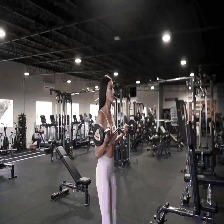

In [14]:
import pandas as pd
import numpy as np
import imageio
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, Image
from sklearn.metrics import confusion_matrix, classification_report

def to_gif(images):
    if images.dtype == np.float32:
        images = (images * 255).astype(np.uint8)
    elif images.dtype == np.uint8:
        pass
    else:
        raise ValueError("Unsupported image dtype.")
    imageio.mimsave('./animation.gif', images, fps=10)
    display(Image(filename='./animation.gif'))

# Visualize sample video
sample_video = frames_from_video_file(file_paths[0], n_frames=10)
to_gif(sample_video)

In [15]:
def augment_video(video, label):
  video = tf.image.random_brightness(video, max_delta=0.1)
  video = tf.image.random_contrast(video, lower=0.9, upper=1.1)

  return video, label


In [16]:
import gc
# Train-test split (80% training, 20% validation)
train_features, val_features, train_targets, val_targets = train_test_split(
    features, targets, test_size=0.2, random_state=42
)

train_ds = (
    tf.data.Dataset.from_tensor_slices((train_features, train_targets))
    .shuffle(len(train_features))
    .batch(batch_size)
    .map(augment_video, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)
valid_ds = (
    tf.data.Dataset.from_tensor_slices((val_features, val_targets))  # Convert data into a TensorFlow dataset
    .shuffle(len(train_features))
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)


# Cleanup unused variables to free up memory
del features, targets
gc.collect()  # Trigger garbage collection

17

In [17]:
from keras import layers, models, optimizers

def build_i3d_model(num_classes=3, input_shape=(10, 224, 224, 3)):
    rgb_inception = tf.keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape[1:]  # (224, 224, 3)
    )

    for layer in rgb_inception.layers:
        layer.trainable = False

    inputs = layers.Input(shape=input_shape)

    x = layers.TimeDistributed(rgb_inception)(inputs)

    # 3D Convolutional layers
    x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((1, 2, 2), strides=(1, 2, 2), padding='same')(x)

    x = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2), strides=(2, 2, 2), padding='same')(x)

    x = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2), strides=(2, 2, 2), padding='same')(x)

    x = layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2), strides=(2, 2, 2), padding='same')(x)

    x = layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2), strides=(2, 2, 2), padding='same')(x)

    # Global pooling and dense layers
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name='i3d_model')

    return model,rgb_inception

# Build and compile the model
i3d_model,rgb_inception = build_i3d_model(num_classes=len(classes), input_shape=(10, 224, 224, 3))

optimizer = optimizers.Adam(learning_rate=1e-4)
i3d_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
i3d_model.summary()

Model: "i3d_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 5, 5, 2048) │    21,802,784 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 10, 5, 5, 64)   │     3,539,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 10, 3, 3, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 10, 3, 3, 128)  │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 5, 2, 2, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 5, 2, 2, 256)   │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 5, 2, 2, 256)   │     1,769,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 3, 1, 1, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 3, 1, 1, 512)   │     3,539,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 3, 1, 1, 512)   │     7,078,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 2, 1, 1, 512)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 2, 1, 1, 512)   │     7,078,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 2, 1, 1, 512)   │     7,078,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 1, 1, 1, 512)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,044,131 (206.16 MB)

 Trainable params: 32,241,347 (122.99 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.2819 - loss: 1.0986

4/4 ━━━━━━━━━━━━━━━━━━━━ 173s 18s/step - accuracy: 0.2865 - loss: 1.0986 - val_accuracy: 0.4062 - val_loss: 1.0985 - learning_rate: 1.0000e-04
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 838ms/step - accuracy: 0.3448 - loss: 1.0980 - val_accuracy: 0.4062 - val_loss: 1.0971 - learning_rate: 1.0000e-04
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 834ms/step - accuracy: 0.3604 - loss: 1.0923 - val_accuracy: 0.4062 - val_loss: 1.0883 - learning_rate: 1.0000e-04
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 842ms/step - accuracy: 0.3667 - loss: 1.0642 - val_accuracy: 0.4062 - val_loss: 1.0904 - learning_rate: 1.0000e-04
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 837ms/step - accuracy: 0.3750 - loss: 1.0389 - val_accuracy: 0.4062 - val_loss: 1.0184 - learning_rate: 1.0000e-04
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 842ms/step - accuracy: 0.3750 - loss: 0.9401 - val_accuracy: 0.4062 - val_loss: 0.9218 - learning_rate: 1.0000e-04
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 852ms/step - accuracy: 0.3750 - loss: 0.8414 - 

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step - accuracy: 0.3875 - loss: 0.7783 - val_accuracy: 0.5625 - val_loss: 0.9213 - learning_rate: 1.0000e-04
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 863ms/step - accuracy: 0.6583 - loss: 0.7224 - val_accuracy: 0.5312 - val_loss: 0.7571 - learning_rate: 1.0000e-04
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 842ms/step - accuracy: 0.6573 - loss: 0.6980 - val_accuracy: 0.4688 - val_loss: 0.8722 - learning_rate: 1.0000e-04


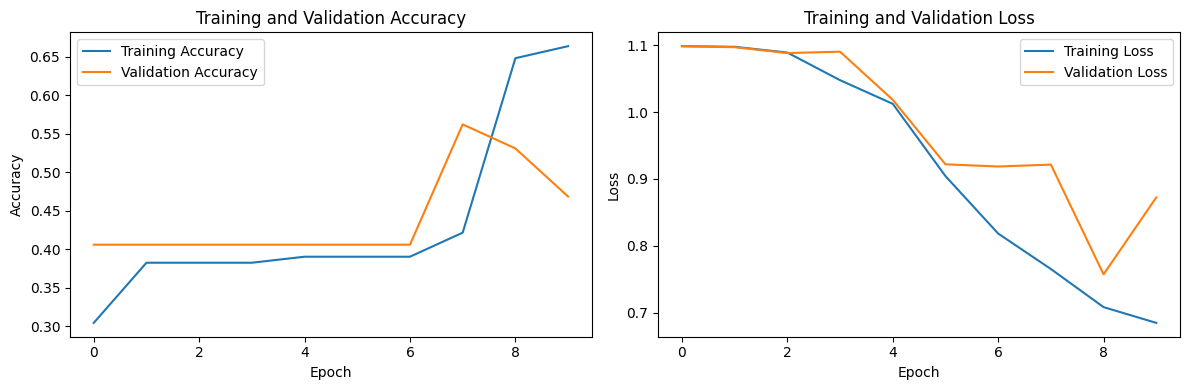

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step - accuracy: 0.5625 - loss: 0.9213

Test Accuracy: 0.5625
Test Loss: 0.9213
1/1 ━━━━━━━━━━━━━━━━━━━━ 45s 45s/step

Confusion Matrix:
[[5 0 8]
 [5 0 7]
 [1 0 6]]


In [18]:
# Add callbacks

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_i3d_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        min_lr=1e-6
    )
]

# Train the model
history = i3d_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs,
    callbacks=callbacks
)

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

# Evaluate the model
test_loss, test_acc = i3d_model.evaluate(valid_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions
y_pred = i3d_model.predict(valid_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix and classification report
print("\nConfusion Matrix:")
print(confusion_matrix(val_targets, y_pred_classes))


Unfroze 30 layers for fine-tuning
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 196s 17s/step - accuracy: 0.6417 - loss: 0.7871 - val_accuracy: 0.5000 - val_loss: 0.8334 - learning_rate: 1.0000e-05
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 947ms/step - accuracy: 0.5458 - loss: 0.7252 - val_accuracy: 0.4375 - val_loss: 0.8178 - learning_rate: 1.0000e-05
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 917ms/step - accuracy: 0.5104 - loss: 0.7242 - val_accuracy: 0.4688 - val_loss: 0.8125 - learning_rate: 1.0000e-05
Epoch 13/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5448 - loss: 0.7063 - val_accuracy: 0.5625 - val_loss: 0.8174 - learning_rate: 1.0000e-05
Epoch 14/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 932ms/step - accuracy: 0.6521 - loss: 0.7003 - val_accuracy: 0.5625 - val_loss: 0.8186 - learning_rate: 1.0000e-05
Epoch 15/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 928ms/step - accuracy: 0.6750 - loss: 0.6962 - val_accuracy: 0.5625 - val_loss: 0.8094 - learning_rate: 1.0000e-05
Epoch 16/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s

4/4 ━━━━━━━━━━━━━━━━━━━━ 81s 27s/step - accuracy: 0.7188 - loss: 0.6913 - val_accuracy: 0.5938 - val_loss: 0.7890 - learning_rate: 1.0000e-05
Epoch 18/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 921ms/step - accuracy: 0.6927 - loss: 0.6904 - val_accuracy: 0.5625 - val_loss: 0.7843 - learning_rate: 1.0000e-05
Epoch 19/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 921ms/step - accuracy: 0.6698 - loss: 0.6892 - val_accuracy: 0.5625 - val_loss: 0.7823 - learning_rate: 1.0000e-05
Epoch 20/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 926ms/step - accuracy: 0.6708 - loss: 0.6885 - val_accuracy: 0.5625 - val_loss: 0.7809 - learning_rate: 1.0000e-05


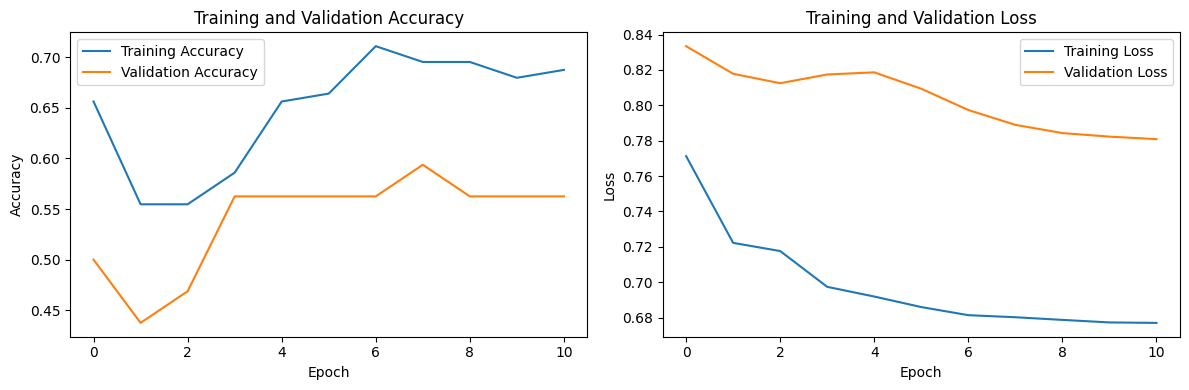

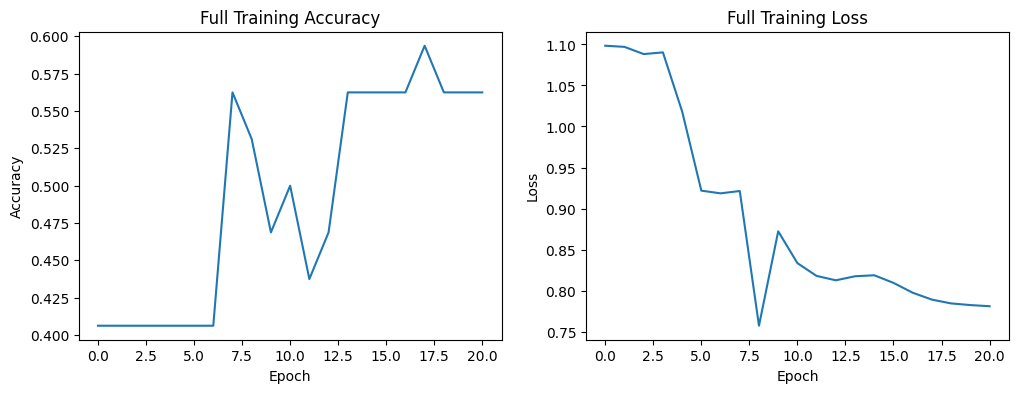


Final Evaluation:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step - accuracy: 0.5938 - loss: 0.7890
Test Accuracy: 0.5938 (Before Fine-Tuning: 0.5625)
Test Loss: 0.7890


In [ ]:
#Fine-Tuning (Unfreeze Partial Backbone)


for layer in rgb_inception.layers[-30:]:
    layer.trainable = True
print(f"Unfroze {len(rgb_inception.layers[-30:])} layers for fine-tuning")

i3d_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history_fine = i3d_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs + 10,
    initial_epoch=history.epoch[-1],
    callbacks=callbacks
)

# Plot fine-tuning results
plot_history(history_fine)

# Combined training plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Combined Val Accuracy')
plt.title('Full Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Combined Val Loss')
plt.title('Full Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Final Evaluation
print("\nFinal Evaluation:")
test_loss, test_acc = i3d_model.evaluate(valid_ds)
print(f"Test Accuracy: {test_acc:.4f} (Before Fine-Tuning: {max(history.history['val_accuracy']):.4f})")
print(f"Test Loss: {test_loss:.4f}")

#predictions
y_pred = i3d_model.predict(valid_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nConfusion Matrix:")
print(confusion_matrix(val_targets, y_pred_classes))

print("\nClassification Report:")
print(classification_report(val_targets, y_pred_classes, target_names=classes))
